In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from scbasset.utils import *
from scbasset.model_class import ModelClass
from scbasset.config import Config

import scbasset.deeptopic_utils as utils
import shap

### Path to input data 

In [3]:
start_directory = '../../../'

cbust_dir = 'result/tfbanformer-TF_to_region_hvg-64_768_4_8_7_32_relu_1-122-'
cbust_type = 'train'

seq_len = 768
# type_data, file_name = 'multiome_example', 'pbmc_multiome'
type_data, file_name = 'TF_to_region', 'TF_to_region_hvg'
# type_data, file_name = 'TF_to_region', 'TF_to_region_marker_genes'

data_path = start_directory + 'data/' + type_data + '/processed/'

ad_file = data_path + file_name + '-' + str(seq_len) + '-ad.h5ad'
h5_file = data_path + file_name + '-' + str(seq_len) + '-train_val_test.h5'

### load the data and trained model

In [4]:
# read h5ad file
ad = anndata.read_h5ad(ad_file)

f = h5py.File(h5_file, 'r')
X = f['X'][:].astype('float32')
Y = f['Y'][:].astype('float32')

X = torch.FloatTensor(X)

n_TFs = Y.shape[1]
ic(n_TFs, Y.shape[0])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
ic| n_TFs: 945, Y.shape[0]: 12835


(945, 12835)

In [5]:
# os.makedirs("../..", exist_ok=True)
print(torch.cuda.is_available())
device = "cuda"
if "cuda" in device and not torch.cuda.is_available():
    device = "cpu"
else:
    torch.cuda.set_device(0)
print(device)

True
cuda


In [6]:
config = Config()
config.h5_file = h5_file
config.bottleneck_size = 64
config.activation_fct = 'gelu'
config.batch_size = 32
# config.model_name = 'scbasset'
config.model_name = 'tfbanformer'
config.num_heads = 8
config.num_transforms = 7
config.repeat = 4
config.tower_multiplier = 1.122

print(config)

# load model
dashboard_model = ModelClass(config, n_TFs=n_TFs)
dashboard_model.activate_analysis()
dashboard_model.load_data(h5_file, shuffle=False)
# dashboard_model.load_weights(device, best=0, trained_model_dir='output/scbasset/TF_to_region_hvg/32_1344_6_TL/')
dashboard_model.load_weights(device, best=0, start_directory=start_directory, trained_model_dir='output/tfbanformer/TF_to_region_hvg/64_768_4_8_7_32_relu_1-122/')
dashboard_model.get_model_summary()
model = dashboard_model.model
model.to(device)

# ReLu not supported yet in deepexplainer (see comment in deepexplainer method)
# config.activation_fct = "relu"
# post_fix = str(config.bottleneck_size) + '_' + str(config.seq_length) + '_' + str(config.repeat)
# post_fix = post_fix if config.model_name == 'scbasset' else post_fix + '_' + str(config.num_heads) + '_' + str(config.num_transforms)
# post_fix += '_' + str(config.batch_size) + '_' + str(config.activation_fct) + '_' + str(config.tower_multiplier).replace('.', '-')

Config(parser_args=None, out_dir='output', bottleneck=32, batch_size=32, learning_rate=0.01, epochs=1000, h5_file='../../../data/TF_to_region/processed/TF_to_region_hvg-768-train_val_test.h5', model_name='tfbanformer', residual_model=False, activation_fct='gelu', seq_length=1344, num_heads=8, repeat=4, num_transforms=7, cuda=2, logs='logs', weights=None, tower_multiplier=1.122)


ic| self.n_TFs: 945, len(X_train): 11552, len(Y_train): 11552
ic| features.shape: torch.Size([32, 768, 4])
ic| trained_model_dir: 'output/tfbanformer/TF_to_region_hvg/64_768_4_8_7_32_relu_1-122/'


TfBanformer(
  (conv_block1): ConvBlock(
    (nonLinear): GELU()
    (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv_layer): Conv1d(4, 288, kernel_size=(17,), stride=(1,), padding=same, bias=False)
    (maxpool_layer): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_tower1): ConvTower(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (nonLinear): GELU()
        (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (conv_layer): Conv1d(288, 288, kernel_size=(5,), stride=(1,), padding=same, bias=False)
        (maxpool_layer): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (nonLinear): GELU()
        (bn_layer): BatchNorm1d(323, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (conv_layer): Conv1d(288, 323, kernel_size=(5,), stride=(1,), padding=same

### score a TF of interest

In [9]:
# Initialize deepexplainer
device = "cpu"
model.to(device)
torch.set_num_threads(16)
rn=np.random.choice(X.shape[0], 250, replace=False)
 
# Tensor = torch.cuda.FloatTensor
model.eval()
samples = X[rn]
# if torch.cuda.is_available():
#     samples = samples.type(Tensor)
explainer = shap.DeepExplainer(model, Variable(samples))

In [10]:
with open(cbust_dir + cbust_type + '_region_ISM_cbust.json') as json_file:
    cbust_data = json.load(json_file)
cbust_data

{'EBF1-PAX5': {'EBF1': {'cbust_mot': {'chr17:3904040-3904540': {'jaspar__MA0154.3': [[442,
       456,
       5.53,
       '+'],
      [442, 456, 5.3, '-'],
      [568, 582, 0.7, '+'],
      [568, 582, 6.03, '-']]},
    'chr22:39487494-39487994': {'jaspar__MA0154.3': [[85, 99, 4.94, '+'],
      [85, 99, 1.21, '-']]},
    'chr6:7545331-7545831': {'jaspar__MA0154.3': [[119, 133, 4.05, '+'],
      [119, 133, 1.83, '-']]},
    'chr22:31251680-31252180': {'jaspar__MA0154.3': [[273, 287, 0.958, '+'],
      [273, 287, 6.78, '-']]},
    'chr19:49473986-49474486': {'jaspar__MA0154.3': [[454, 468, 3.74, '+'],
      [454, 468, 3.66, '-']]},
    'chr19:48365004-48365504': {'jaspar__MA0154.3': [[236, 250, 4.98, '+'],
      [236, 250, 3.13, '-'],
      [352, 366, 3.6, '+'],
      [352, 366, 2.55, '-'],
      [713, 727, 3.59, '+'],
      [713, 727, 2.3, '-']]},
    'chr1:85330764-85331264': {'jaspar__MA0154.3': [[433, 447, 4.37, '+'],
      [433, 447, 5.44, '-'],
      [172, 186, 3.48, '+'],
      [1

In [11]:

combinations = generate_combinations(cbust_data, ad)


250
724
804
822
435


In [12]:
TF_id = 804
TF_name = ad.obs['TF'][TF_id] + ' ' + ad.obs['cell_line'][TF_id] + ' ' + ad.obs['exp_id'][TF_id] + ' ' + ad.obs['motif_model'][TF_id] 
TF_name

'SPI1 MDMmonocyte_derived_macrophages EXP047757 MA0080.5'

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using non-full backward hooks on a Module that does not take as input a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_input. Please use register_full_backward_hook to get the documented behavior.


ic| shap_values_: [array([[[-0.01357689, -0.0163579 , -0.02943008, -0.01922121],
                          [-0.01552131, -0.01958919, -0.02464253, -0.02002441],
                          [-0.00912171, -0.0256351 , -0.02134352, -0.02717444],
                          ...,
                          [ 0.0360922 , -0.00134664, -0.03026279,  0.00389236],
                          [-0.02209169, -0.00352994, -0.01441777, -0.00701906],
                          [ 0.01253232, -0.00123006,  0.00362585, -0.01028256]]])]


ic| seq_shape: torch.Size([1, 768, 4])
ic| arrr_A.shape: (945, 768)
    arrr_C.shape: (945, 768)
    arrr_G.shape: (945, 768)
    arrr_T.shape: (945, 768)
100%|███████████████████████████████████████████████████████| 768/768 [00:12<00:00, 62.73it/s]
ic| arrr_A[0][0:2]: array([-1.03476048e-02, -8.44001770e-05])
    arrr_C[0][0:2]: array([ 0.02844906, -0.00545168])
    arrr_G[0][0:2]: array([-0.00704885,  0.        ])
    arrr_T[0][0:2]: array([ 0.        , -0.01155758])


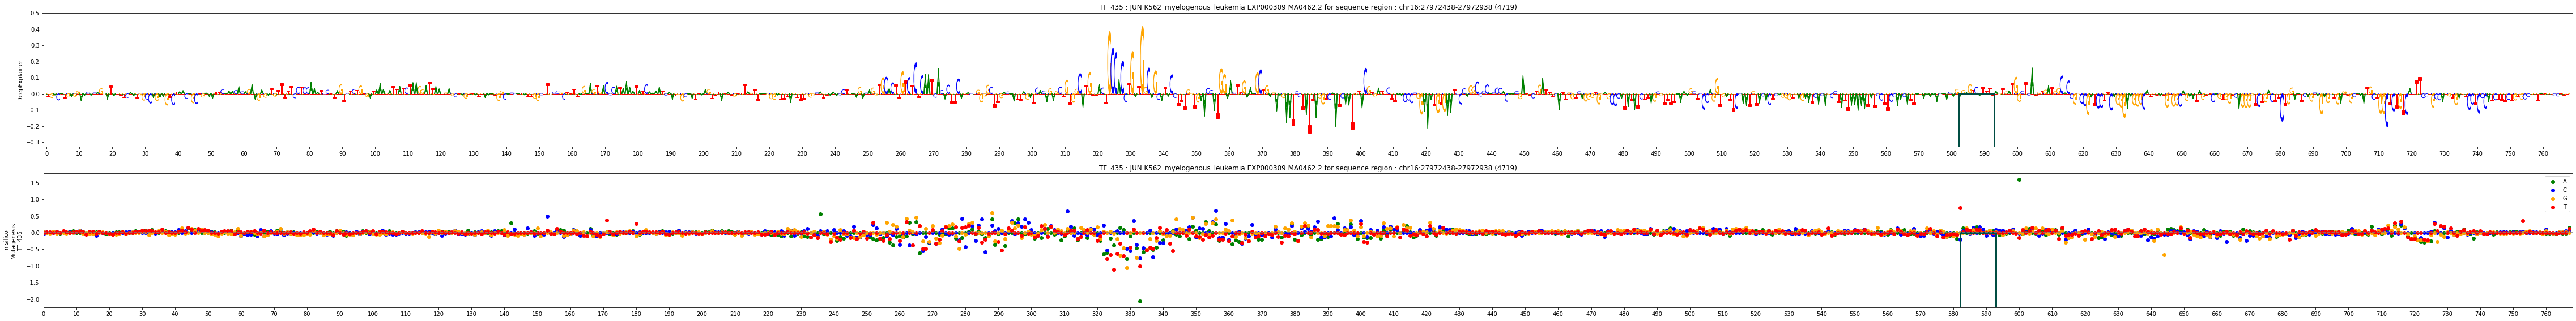

In [16]:

ntrack = 4
fig = plt.figure(figsize=(80,ntrack*5))
axes = [None, None]

track_no1=1

combi = ['JUN', 4719, 435]
TF_n, seq_id, TF_id = combi
seq_onehot = X[seq_id:seq_id+1]

TF_name = ad.obs['TF'][TF_id] + ' ' + ad.obs['cell_line'][TF_id] + ' ' + ad.obs['exp_id'][TF_id] + ' ' + ad.obs['motif_model'][TF_id] 

region_id = ad.var.index[seq_id]
region_str = '{} ({})'.format(region_id, seq_id)

device = "cpu"
model.to(device)
torch.set_num_threads(16)
ax_id = 0
axes[ax_id] = utils.plot_deepexplainer_givenax(explainer=explainer, fig=fig, ntrack=ntrack, 
                                    track_no=track_no1, seq_onehot=seq_onehot, 
                                    TF = TF_id, TF_name=TF_name, region_id=region_str)

plot_cbust_on_ISM_chap(combi, cbust_data, axes[ax_id], region_id)

device = "cuda"
model.to(device)
track_no2=2
# Plot in silico mutagenesis for the selected topic
ax = utils.plot_mutagenesis_givenax(model=model, fig=fig, ntrack=ntrack, track_no=track_no2, 
                                seq_onehot=seq_onehot, num_classes=n_TFs, 
                                TF = TF_id, TF_name=TF_name, region_id=region_str)

plot_cbust_on_ISM_chap(combi, cbust_data, ax, region_id)

fig.show()

In [ ]:
# ntrack = 4
# fig = plt.figure(figsize=(80,ntrack*5))

# TF_name = ad.obs['TF'][TFs[0]] + ' ' + ad.obs['cell_line'][TFs[0]] + ' ' + ad.obs['exp_id'][TFs[0]] + ' ' + ad.obs['motif_model'][TFs[0]] 
# Plot deepexplainer for the selected topics
# with torch.no_grad():
# track_no1=1
# ax1 = utils.plot_deepexplainer_givenax(explainer=explainer, fig=fig, ntrack=ntrack, 
#                                     track_no=track_no, seq_onehot=seq_onehot, 
#                                     TF = TFs[0], TF_name=TF_name, region_id=region_id)

# single_m = cbust_data['EBF1']['cbust_mot']['chr9:37773636-37774136']
# threshold, st, end = 3, 0, 768
# for motif in [xx for xx in cbust_data['EBF1']['all_mot'] if xx in list(single_m.keys())]: 
#     color = cbust_data['EBF1']['all_mot'][motif][0]           
#     for single_motif in single_m[motif]:
#         if single_motif[2] >= threshold:
#             if single_motif[3]=='-':
#                 ax1.add_patch(matplotlib.patches.Rectangle(xy=[single_motif[0]-st,-1*single_motif[2]] ,
#                                                     width=single_motif[1]-single_motif[0] ,
#                                                     height=single_motif[2],
#                                                     color=color, fill=False, linewidth=3))

# Plot in silico mutagenesis for the selected topic
# track_no=2
# _ = utils.plot_mutagenesis_givenax(model=model, fig=fig, ntrack=ntrack, track_no=track_no, 
#                                 seq_onehot=seq_onehot, num_classes=n_TFs, 
#                                 TF = TFs[0], TF_name=TF_name, region_id=region_id)


# seq_id = 1795
# seq_onehot = X[seq_id:seq_id+1]

# TF_name = ad.obs['TF'][TFs[1]] + ' ' + ad.obs['cell_line'][TFs[1]] + ' ' + ad.obs['exp_id'][TFs[1]] + ' ' + ad.obs['motif_model'][TFs[1]]
# # Plot deepexplainer for the selected topics
# track_no=3
# ax2 = utils.plot_deepexplainer_givenax(explainer=explainer, fig=fig, ntrack=ntrack, track_no=track_no, 
#     seq_onehot=seq_onehot, TF = TFs[1], TF_name=TF_name, region_id=region_id)

# #to adjust y axis of two deepexplainer plot on the same region
# min_ = np.min([ax1.get_ylim()[0],ax2.get_ylim()[0] ])
# max_ = np.max([ax1.get_ylim()[1],ax2.get_ylim()[1] ])
# ax1.set_ylim([min_, max_])
# ax2.set_ylim([min_, max_])

# track_no=2
# _ = utils.plot_mutagenesis_givenax(model=model, fig=fig, ntrack=ntrack, track_no=track_no, seq_onehot=seq_onehot, num_classes=n_TFs, TF = indexes_[0]+1)


# Plot in silico mutagenesis for the selected topic
# track_no=4
# _ = utils.plot_mutagenesis_givenax(model=model, fig=fig, ntrack=ntrack, track_no=track_no, 
#     seq_onehot=seq_onehot, num_classes=n_TFs, TF = TFs[1], TF_name=TF_name, region_id=region_id)

: 

: 